# Welcome to Color by Flavor!
This is the first part of the **MtG Classy Flavor** project. Here we will be classifying a card's color from its flavor text. We will go over getting cards from the Scryfall API, parsing the card data with Pandas, and fitting a classifier with ScikitLearn.  

## Get Card Data from Scryfall using the Scryfall API
**Scryfall** is a powerful database and search engine for Magic: The Gathering cards. 
We will use their API to download all cards that have flavor text. Since cards are often reprinted with different flavor text each time, we will import all printed versions of every card in the game, but exclude those that don't contain flavor text. 

https://scryfall.com/docs/api

We then convert the data to a pandas dataframe and isolate unique instances of flavor text. Finally we will save a local copy of the data so that we don't have to access the API repeatedly. New cards are only added every month or so. 



In [4]:
# Set these parameters for saving and loading data
output_dir = os.getcwd()
file_name = 'CardData.pkl'
full_file = output_dir+"\\"+file_name

In [6]:
# Scryfall query parameters:
order = "cmc"
# Unique printings of cards that have flavor text, English prints only, and ignoring "funny" cards (like those from the un-sets or holiday cards)
querystring = "has%3Aflavor+unique%3Aprints+%2Dis%3Dfunny+language%3Den&unique=prints"
url = f"https://api.scryfall.com/cards/search?order={order}&q={querystring}"

from CF_standard_functions import file_age_in_hours # Custom package with simple functions 
import os
import pickle 

# First check if data already exists and is "fresh". If so, load it in:
# Here defining fresh as newer than 30 days
if os.path.isfile(full_file) and file_age_in_hours(full_file) < 24*30 :
    print('Loading data from disk...')
    file = open(full_file, 'rb')
    data = pickle.load(file)
    file.close()
    print('Done!')
else:# Otherwise get the data from Scryfall. This can take a while... 
    sf_response = requests.get(url).json()
    data = sf_response['data']
    curr_page = 1;
    print(f"Page {curr_page}",end='\r')
    while sf_response['has_more']:  
        time.sleep(0.2) # Be polite and patient with the API
        url_next = sf_response['next_page']
        sf_response = requests.get(url_next).json()
        data_new = sf_response['data']
        data = data + data_new
        curr_page += 1 
        print(f"Page {curr_page}",end='\r')
    
    print(f"Loaded {curr_page} pages of cards")
    print("Saving...")
    data = pd.DataFrame(data)
    data.drop_duplicates(subset='flavor_text',inplace=True)
    file = open(full_file,'wb')    
    pickle.dump(data, file)
    file.close()
    print("Done!")
    
nCards = len(data)
print(nCards,"cards in data set")

Loading data from disk...
Done!
20546 cards in data set


### Organize cards by color
In our first task we will classify flavor text by color. For convenience, we will make a new dataframe subsetting only the name, flavortext, and color of monocolored cards (i.e. excluding cards that have no color or are multiple colors).\
To make separating cards by colors easier, we add a Boolean variable to the dataframe for each color. We also add a Boolean for whether or not a card is monocolored. \
Finally, sort our cards in traditional **WUBRG** order (**W**hite, Bl**u**E, **B**lack, **R**ed, **G**reen) by setting the _colors_ variable to a categorical value.


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [11]:
data = pd.DataFrame(data)
data.drop_duplicates(subset='flavor_text',inplace=True)

for c in ['W','U','B','R','G']:
    tf = data.colors.apply(lambda x : np.shape(x) != (0,) and np.any(np.isin(x,c)))
    data['is_'+c] = tf

tf = np.sum(data.loc[:][['is_W','is_U','is_B','is_R','is_G']],axis=1) == 1
data['is_monocolor'] = tf

data_monocolor = data.loc[data.is_monocolor][['name','colors','flavor_text']].copy()
data_monocolor['colors'] = data_monocolor.colors.apply(lambda x: ''.join(x)) # Convert from list to string

data_monocolor['colors'] = pd.Categorical(data_monocolor['colors'],ordered=True)
data_monocolor['colors'] = data_monocolor['colors'].cat.reorder_categories(['W','U','B','R','G'])
data_monocolor.sort_values('colors',ascending=True,inplace=True)
data_monocolor.sample(8)

C:\Users\gordo\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,name,colors,flavor_text
17401,Citywide Bust,W,"""Oh, you fellas are going to love the lockup. ..."
3734,Flaxen Intruder // Welcome Home,G,The middle blade was just right.
19936,Hero's Downfall,B,Odric resisted the vampire's curse with all hi...
14288,"Sram, Senior Edificer",W,"""As this conflict grows, it gets harder to pre..."
34203,Knowledge and Power,R,"""Information is a powerful weapon.""\n—Cymede, ..."
32573,Aven Tactician,W,"The aven are admired, for they are able to fly..."
18872,Fevered Strength,B,"""The fever clouds the mind as it energizes the..."
16922,Bog Raiders,B,"""Let weak feed on weak, that we may divine the..."


In [12]:
print(f"Post-trimming: {data_monocolor.shape[0]} unique instances of flavor text on monocolor cards")

Post-trimming: 16007 unique instances of flavor text on monocolor cards


### Prepare data for classification

We will be classifying our cards with ScikitLearn. SckitLearn needs categories to be described by numbers, not strings. So we will map each color string to a number:

In [14]:
label_map = {'W':0,
             'U':1,
             'B':2,
             'R':3,
             'G':4}
data_monocolor['label'] = data_monocolor['colors'].map(label_map)
data_monocolor.sample(5)

,name,colors,flavor_text,label
10954,Kami of the Crescent Moon,U,"""He's a lot like me, that masterless little ka...",1
14120,Sonic Burst,R,Music scythes the savage beast.,3
5601,Savaen Elves,G,"""Purity of magic can only come from purity of ...",4
35988,Territorial Baloth,G,Its territory is defined by wherever it is at ...,4
21621,Navigator's Ruin,U,"""You won't be needing this. Or this. Or these ...",1


### Split data into train and test sets

Using ScikitLearn's train_test_split, split our ~16,000 cards into a training set (75%) and a test set (25%). 

In [15]:
from sklearn.model_selection import train_test_split

flavor_train, flavor_test, label_train, label_test = train_test_split(
        data_monocolor['flavor_text'], data_monocolor['label'], test_size=0.25, random_state=1)

print('Training set consists of',flavor_train.shape[0],'cards.')
print('Test set consists of',flavor_test.shape[0],'cards.')


Training set consists of 12005 cards.
Test set consists of 4002 cards.


## Design our Model!
First we _tokenize_ the words in flavor text and convert them to numeric values, ignoring terms that are extremeley common and those that only appear 3 or fewer times in the training set. \
Then, we fit a Linear Support Vector Classifier on our training data. \
These two steps can be wrapped up together in a ScikitLearn Pipeline object.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
my_vectorizer = TfidfVectorizer(min_df = 3,max_df=0.95)
my_linSVC = LinearSVC(C=1)
pipe = Pipeline([('vect',my_vectorizer),
               ('clf',my_linSVC)])

pipe = pipe.fit(flavor_train,label_train)

#### Measure model accuracy on test data

In [18]:
label_predict = pipe.predict(flavor_test)
performance = np.round(sum(label_predict == label_test) / len(label_test) , 3)*100
print('Classifier accuracy is %s%%' % performance)

Classifier accuracy is 50.6%


#### Visualize model performance with a confusion matrix

              precision    recall  f1-score   support

           W       0.48      0.50      0.49       847
           U       0.47      0.53      0.50       729
           B       0.50      0.52      0.51       773
           R       0.55      0.49      0.52       851
           G       0.53      0.50      0.51       802

    accuracy                           0.51      4002
   macro avg       0.51      0.51      0.51      4002
weighted avg       0.51      0.51      0.51      4002



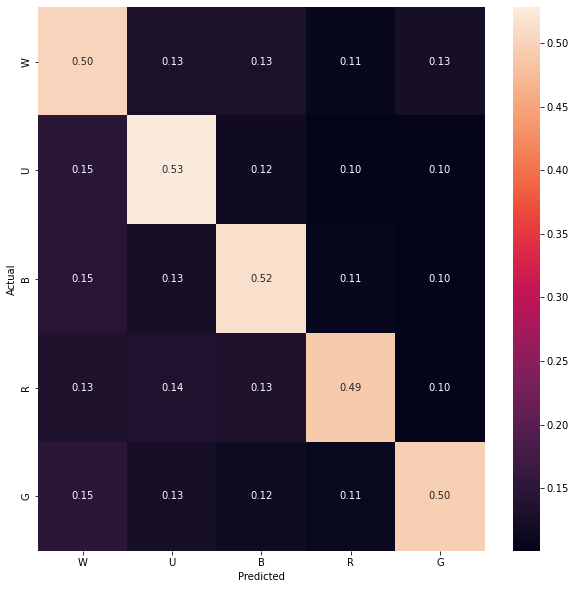

In [19]:
from sklearn import metrics
import seaborn as sns

print(metrics.classification_report(label_test, label_predict,target_names = [str(i) for i in label_map]))

cm = metrics.confusion_matrix(label_test, label_predict,normalize='true',
                              labels=list(label_map.values()))

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=[str(i) for i in label_map],yticklabels=[str(i) for i in label_map])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


**Not too shabby!** \
Our classifier gets the correct color a hair over 50% of the time. This might not seem that good, but remember that there are five colors, so we would only have about a 20% hit rate by randomly guessing. 

We can also write our own flavor text and see what color our model thinks it belongs to!

In [20]:
new_flavor_text = ['Goblins sure do smell bad',
              'Your spell was a mistake and now it is gone',
              'Trees are the most beautiful thing',
              'Death cannot stop the wicked',
              'The angelic choir sings loftily over the clouds',
              '"Some like it hot" -Chandra Nalaar']

new_color_predictions = pipe.predict(new_flavor_text)
# Reverse-lookup color mapping    
for txt,col in zip(new_flavor_text,new_color_predictions):
    print(f"{txt} --> {[str(i) for i in label_map][col]}")

Goblins sure do smell bad --> R
Your spell was a mistake and now it is gone --> U
Trees are the most beautiful thing --> G
Death cannot stop the wicked --> B
The angelic choir sings loftily over the clouds --> W
"Some like it hot" -Chandra Nalaar --> R


**Lets see if we can do better by tokenizing word pairs as well as individual words**

In [23]:
performance = np.round(sum(label_predict == label_test) / len(label_test) , 3)*100
print('Classifier hit rate is %s%%' % performance)
pipe.set_params(vect__ngram_range = (1,2))
pipe.fit(flavor_train,label_train)
color_predict = pipe.predict(flavor_test)


Classifier hit rate is 50.6%


Looks like that didn't make a difference. Lets do a more thorough optimization using a parameter grid search:
(this takes a long time to run, check the Python kernal for progress updates)

In [24]:
from sklearn.model_selection import GridSearchCV 

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)] ,
    'vect__max_df': [0.8,0.9,0.95,0.99],
    'vect__min_df': [1,2,3],
    'clf__C':       [0.01,0.1,1,10]}
gs = GridSearchCV(pipe, parameters, n_jobs=-1,verbose=3)
gs.fit(flavor_train,label_train)

gs_df = pd.DataFrame.from_dict(gs.cv_results_)

print(gs.best_score_)
print(gs.best_params_)
gs_df.head()

Fitting 5 folds for each of 96 candidates, totalling 480 fits
0.5192003331945023
{'clf__C': 0.1, 'vect__max_df': 0.8, 'vect__min_df': 1, 'vect__ngram_range': (1, 1)}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_vect__max_df,param_vect__min_df,param_vect__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.486111,0.019365,0.061212,0.001832,0.01,0.8,1,"(1, 1)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.461474,0.462307,0.452312,0.460225,0.458559,0.458975,0.003563,77
1,1.422317,0.049046,0.126829,0.010149,0.01,0.8,1,"(1, 2)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.452312,0.452312,0.449813,0.449396,0.438151,0.448397,0.005266,93
2,0.503514,0.012228,0.056412,0.002653,0.01,0.8,2,"(1, 1)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.463140,0.465223,0.453561,0.459392,0.459808,0.460225,0.003969,69
3,0.916004,0.043979,0.109826,0.003188,0.01,0.8,2,"(1, 2)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.463973,0.464390,0.449396,0.455643,0.456060,0.457893,0.005653,85
4,0.460304,0.040564,0.063015,0.012459,0.01,0.8,3,"(1, 1)","{'clf__C': 0.01, 'vect__max_df': 0.8, 'vect__m...",0.461474,0.466056,0.453145,0.461474,0.462724,0.460975,0.004259,65


**Plot the relationships between model parameters and model score**

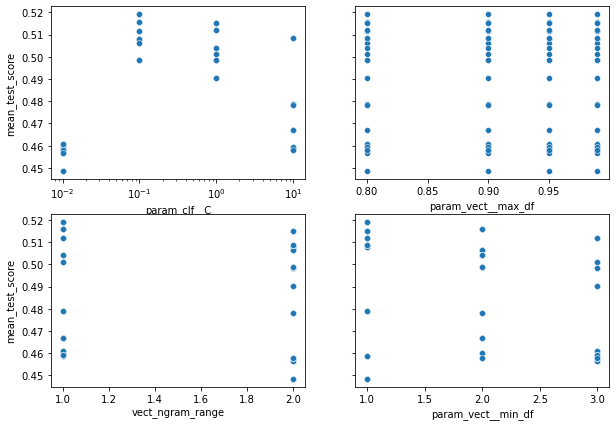

In [81]:
fig,ax = plt.subplots(2,2,sharey=True,figsize=[10,7])
sns.scatterplot(data=gs_df,ax=ax[0][0],x='param_clf__C',y='mean_test_score')
sns.scatterplot(data=gs_df,ax=ax[0][1],x='param_vect__max_df',y='mean_test_score')
ngram_range_max = [i[1] for i in gs_df.loc[:,'param_vect__ngram_range']]
sns.scatterplot(data=gs_df,ax=ax[1][0],x=ngram_range_max,y='mean_test_score')
ax[1][0].set_xlabel('vect_ngram_range')
sns.scatterplot(data=gs_df,ax=ax[1][1],x='param_vect__min_df',y='mean_test_score')
ax[0][0].set_xscale('log')

From these plots, it looks like the C parameter of the LinearSVC is the most important parameter to adjust, though differences in how we vectorize the text can help a bit.\
_max_cf_ has little effect, and a higher _max_cf_ value means we are removing more words from our lexicon, so let's leave that at 0.95 to keep more words in our model without hurting performance.

**Retrain the model with these new parameters**

In [82]:
pipe.set_params(vect__max_df = 0.95,
                vect__min_df=1,
                vect__ngram_range=(1,1),
                clf__C = 0.1)
pipe.fit(flavor_train,label_train)
label_predict = pipe.predict(flavor_test)
performance = np.round(sum(label_predict == label_test) / len(label_test) , 4)*100
print('Optimized classifier hit rate is %s%%' % performance)

Optimized classifier hit rate is 52.05%


## Investigate the Model
Now that we have an optimized model, lets look into what types of text the model does well on and the model does poorly on. \
For now, we will only look at cards in our test set (to avoid re-running the model several times). 

One likely cause of misclassification is from cards with very short flavor text. We can check this by plotting the portion of correct classifications as a function of flavor text length.

First, let's look at the distribution of the number of words in flavor text, binning by 5 words:

[Text(0, 0.5, 'Count of Cards'),
 Text(0.5, 0, 'Number of Words in Flavor Text')]

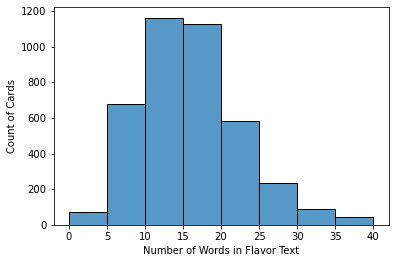

In [179]:
# Put test data into a dataframe for easier plotting and indexing
test_df = pd.DataFrame(data={'Text':flavor_test,'Label':label_test})
test_df['Word_Count'] = test_df.Text.apply(lambda x : len(x.split()))

bins = np.arange(0,45,5)
ax = plt.axes()
sns.histplot(data=test_df,x='Word_Count',bins=bins,ax=ax)
ax.set(ylabel='Count of Cards',xlabel='Number of Words in Flavor Text')

Now for each bin of flavor text word count, find the proportion of cards in that bin that are correctly classified:

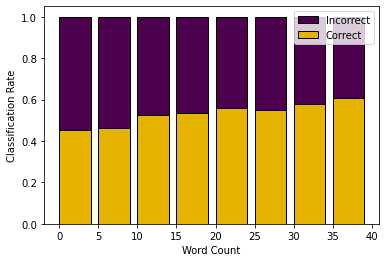

In [180]:
# Preallocate arrays
counts_correct = np.zeros(len(bins)-1)
counts_all =   np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    sub_data = test_df[(test_df.Word_Count > bins[i]) & (test_df.Word_Count <= bins[i+1])][['Text','Label']]
    predicted = pipe.predict(sub_data.Text)
    counts_correct[i] = sum(predicted == sub_data.Label)
    counts_all[i] = sub_data.shape[0]
plot_bin_width = (bins[1]-bins[0])*0.8
    
hit_rate = counts_correct / counts_all
bar_x = [np.mean([y,z]) for y,z in zip(bins[:-1],bins[1:])]
bar_df = pd.DataFrame({'Bin':bins[:-1],'Correct_Rate':hit_rate,'Incorrect_Rate':1-np.array(hit_rate)})
miss_bar = plt.bar(bins[:-1],np.ones(np.size(hit_rate)),align='edge',width=plot_bin_width,
                   edgecolor='k',color=[0.3,0,0.3])
hit_bar = plt.bar(bins[:-1],hit_rate,align='edge',width=plot_bin_width,
                  edgecolor='k',color=[0.9,0.7,0])
plt.ylabel('Classification Rate')
plt.xlabel('Word Count')
miss_bar.set_label('Incorrect')
hit_bar.set_label('Correct')
plt.legend()

Indeed, it looks like longer texts are slightly easier to classify! \
But can we prove this statistically?